In [1]:
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from IPython.display import Image
import copy
import warnings
warnings.simplefilter("ignore")
from IPython.display import display, HTML

class Figure:
    
    
    def __init__(self):
        
        self.d20 = ["AirlinesCodrnaAdult",
                    "Amazon",
                    "AP_Breast_Lung",
                    "arrhythmia",
                    "audiology",
                    "connect-4",
                    "dataset_31_credit-g",
                    "electricity-normalized",
                    "eye_movements",
                    "gina_agnostic",
                    "hiva_agnostic",
                    "KDDCup99",
                    "MagicTelescope",
                    "openml_phpJNxH0q",
                    "phpZrCzJR",
                    "pokerhand-normalized",
                    "solar-flare_1",
                    "umistfacescropped",
                    "vowel",
                    "wine-quality-red"]
        self.d10 = ["dataset_39_ecoli",
                    "synthetic_control",
                    "avila-tr",
                    "phpGUrE90",
                    "dataset_60_waveform-5000",
                    "dataset_186_satimage",
                    "dataset_40_sonar",
                    "phpmPOD5A",
                    "AP_Omentum_Ovary",
                    "phprAeXmK"]
        
        
        skout=r"C:\Users\HassanEldeeb\Documents\GitHub\AutoMLBenchmarking\logs_search_space/skout.xlsx"
        self.skout = pd.read_excel(skout,
                              null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n', 'None'])
        self.skout = self.skout[['dataset', 'time_budget', 'methods', 'f1score']]
        self.skout.methods = self.skout.methods.replace("['adaboost', 'bernoulli_nb', 'decision_tree', 'extra_trees', 'gaussian_nb', 'gradient_boosting', 'k_nearest_neighbors', 'lda', 'liblinear_svc', 'libsvm_svc', 'multinomial_nb', 'passive_aggressive', 'qda', 'random_forest', 'sgd']", "fc")
        self.skout.methods = self.skout.methods.replace("['decision_tree', 'libsvm_svc', 'random_forest']", "3c")
        self.skout.methods = self.skout.methods.replace("['libsvm_svc']", "1c")
        self.skout.methods = self.skout.methods.replace("['decision_tree']", "1c")
        self.skout.methods = self.skout.methods.replace("['random_forest']", "1c")
        self.skout = self.clean(self.skout, is_30=True)
        
        atm=r"C:\Users\HassanEldeeb\Documents\GitHub\AutoMLBenchmarking\logs_search_space/atmout.xlsx"
        self.atm = pd.read_excel(atm,
                              null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n', 'None'])
        self.atm = self.atm[['dataset', 'time_budget', 'methods', 'f1score']]
        self.atm.methods = self.atm.methods.replace("['logreg', 'svm', 'sgd', 'dt', 'et', 'rf', 'gnb', 'mnb', 'bnb', 'gp', 'pa', 'knn', 'mlp', 'ada']", "fc")
        self.atm.methods = self.atm.methods.replace("['rf', 'dt', 'svm']", "3c")
        self.atm.methods = self.atm.methods.replace("['logreg', 'dt', 'knn']", "def")
        self.atm.methods = self.atm.methods.replace("['svm']", "1c")
        self.atm.methods = self.atm.methods.replace("['dt']", "1c")
        self.atm.methods = self.atm.methods.replace("['rf']", "1c")
        self.atm = self.clean(self.atm)
        
        tpot=r"C:\Users\HassanEldeeb\Documents\GitHub\AutoMLBenchmarking\logs_search_space/tpot.xlsx"
        self.tpot = pd.read_excel(tpot,
                              null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n', 'None'])
        self.tpot = self.tpot[['dataset', 'time_budget', 'methods', 'f1score']]
        self.tpot.methods = self.tpot.methods.replace("default", "fc")
        self.tpot.methods = self.tpot.methods.replace("3C", "3c")
        self.tpot.methods = self.tpot.methods.replace("SVC", "1c")
        self.tpot.methods = self.tpot.methods.replace("DT", "1c")
        self.tpot.methods = self.tpot.methods.replace("RF", "1c")
        self.tpot = self.clean(self.tpot)
        
    
    
    def clean(self, df, is_30 = False):
        df = df[df.f1score != 0]
#         if is_30:
#             datasets = self.d20 + self.d10
#         else:
        datasets = self.d20
        df = df[df.dataset.isin(datasets)]
        for d in datasets:
            for t in [10, 30, 60]:
                for ss in ['fc', '3c', '1c']:
                    if df[(df.methods == ss) & (df.time_budget == t) & (df.dataset == d)].shape[0] == 0:
                        new_row = {'dataset': d, 'time_budget': t, 'methods':ss, 'f1score':0}
                        df = df.append(new_row, ignore_index=True)
        return df
    
    
    def get_sheet(self):
        return self.sheet
    
    def check(self):
        return pd.DataFrame({ 'diff': self.diff, 'va11': self.var1, 'var2': self.var2 })
    
    
    def compare_acc_scatter(self, var1, var2, x_label, y_label, title,
                           legend_missing='Failed Run', legend_negative='-ve Dif',
                           legend_zero='Zero Dif', legend_positive='+ve Dif',
                           fig_size = (8, 8), legend_ncols=4, legend_x_shift=0, y_limit=None,
                           x_axis_grid=False, divide_data=False):
       
        font_size=16
        self.var1, self.var2 = var1.reset_index(drop=True).fillna(0), var2.reset_index(drop=True).fillna(0)
        argsort = (self.var1 - self.var2).argsort()
        self.var1 = self.var1[argsort].reset_index(drop=True)
        self.var2 = self.var2[argsort].reset_index(drop=True)

        self.diff = (self.var1 - self.var2).reset_index(drop=True)
        y_limit = [1.1* min(self.diff), 1.1 * max(self.diff)]
        if y_limit[0] == 0:
            y_limit[0] = -0.1 * y_limit[1]
        fig, ax = plt.subplots(figsize=fig_size)

        dot_size=100
        yy = self.diff[(self.diff <= -0.01) & (self.var1 != 0.0) & (self.var2 != 0)]
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'red',
               marker ='v',
               label = 'Negative',
                  s=dot_size)

        yy = self.diff[(self.diff > -0.01) & (self.diff < 0.01) & (self.var1 != 0.0) & (self.var2 != 0)]
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'blue',
               marker ='.',
               label = 'Same',
                  s=dot_size*3)

        yy = self.diff[(self.diff >= 0.01)  & (self.var1 != 0.0) & (self.var2 != 0)]
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'green',
               marker ='^',
               label = 'Positive',
                  s=dot_size)

        yy = self.diff[(self.var1 == 0.0) | (self.var2 == 0)]
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'darkorange',
               marker ='x',
               label = 'Failed',
                  s=dot_size)

        l = ax.legend( ncol=legend_ncols, bbox_to_anchor=(legend_x_shift, 1), loc='lower left', fontsize=font_size)
        
        plt.xlabel(x_label, fontsize=font_size*1.2)
        plt.ylabel(y_label, fontsize=font_size*1.2)
        ax.yaxis.grid() # horizontal lines
        if x_axis_grid:
            ax.xaxis.grid()
        plt.ylim(y_limit)
        plt.xlim([-1,1+self.var1.shape[0]])
        plt.xticks(np.arange(0, 1+self.var1.shape[0], 10), fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.title(label = title, pad = 40, fontsize=font_size)
        plt.tight_layout()
        plt.savefig('./search_space_figs/' + title.replace(' ', '_') + '.pdf', format='pdf')
        plt.show()
        return


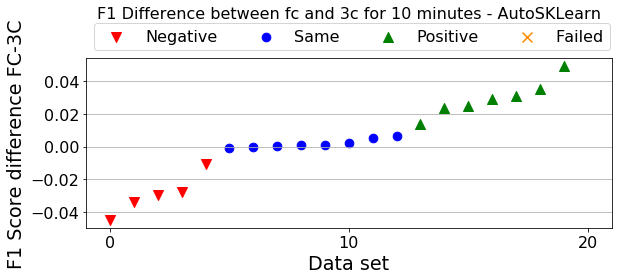

In [2]:
fig = Figure()
var1 = fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.skout[(fig.skout.methods == '3c') & (fig.skout.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference FC-3C', 'F1 Difference between fc and 3c for 10 minutes - AutoSKLearn', fig_size = (9, 4))

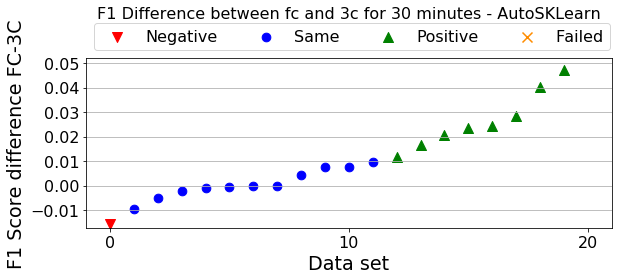

,dataset,time_budget,methods,f1score
1337,KDDCup99,30,fc,0.999717
1340,KDDCup99,30,fc,0.999741
1341,KDDCup99,30,fc,0.999741


,dataset,time_budget,methods,f1score
976,KDDCup99,30,3c,0.999660
982,KDDCup99,30,3c,0.999741
983,KDDCup99,30,3c,0.999806


In [3]:
var1 = fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.skout[(fig.skout.methods == '3c') & (fig.skout.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference FC-3C', 'F1 Difference between fc and 3c for 30 minutes - AutoSKLearn', fig_size = (9, 4))
df = pd.DataFrame({'dataset': fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().index.get_level_values(0).values, 'var1': var1.values, 'var2': var2.values, 'diff': var1.values - var2.values})
display(fig.skout[(fig.skout.dataset == 'KDDCup99') & (fig.skout.methods == 'fc') & (fig.skout.time_budget==30)])
display(fig.skout[(fig.skout.dataset == 'KDDCup99') & (fig.skout.methods == '3c') & (fig.skout.time_budget==30)])

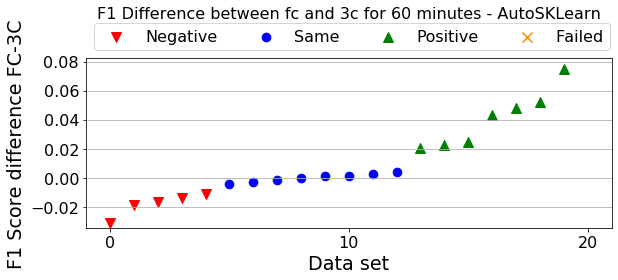

In [4]:
var1 = fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.skout[(fig.skout.methods == '3c') & (fig.skout.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference FC-3C', 'F1 Difference between fc and 3c for 60 minutes - AutoSKLearn', fig_size = (9, 4))


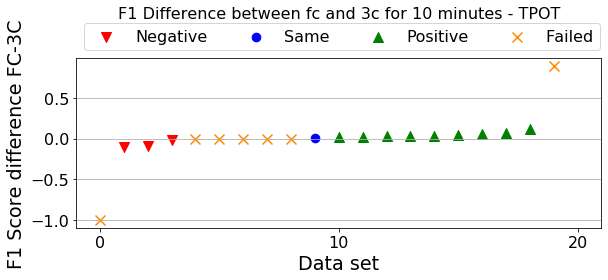

In [5]:
var1 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.tpot[(fig.tpot.methods == '3c') & (fig.tpot.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference FC-3C', 'F1 Difference between fc and 3c for 10 minutes - TPOT', fig_size = (9, 4))

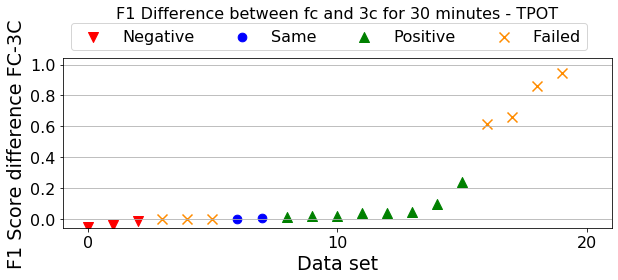

In [6]:
var1 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.tpot[(fig.tpot.methods == '3c') & (fig.tpot.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference FC-3C', 'F1 Difference between fc and 3c for 30 minutes - TPOT', fig_size = (9, 4))

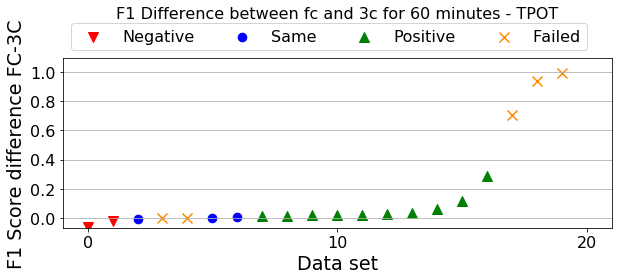

In [7]:
var1 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.tpot[(fig.tpot.methods == '3c') & (fig.tpot.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference FC-3C', 'F1 Difference between fc and 3c for 60 minutes - TPOT', fig_size = (9, 4))

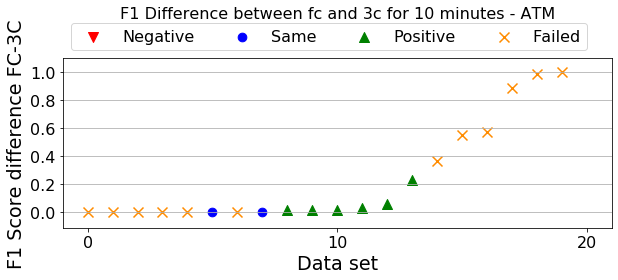

In [8]:
var1 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.atm[(fig.atm.methods == '3c') & (fig.atm.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference FC-3C', 'F1 Difference between fc and 3c for 10 minutes - ATM', fig_size = (9, 4))

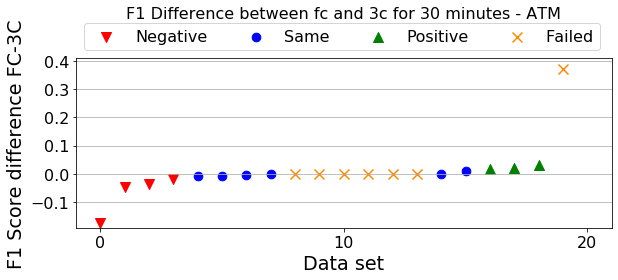

In [9]:
var1 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.atm[(fig.atm.methods == '3c') & (fig.atm.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference FC-3C', 'F1 Difference between fc and 3c for 30 minutes - ATM', fig_size = (9, 4))

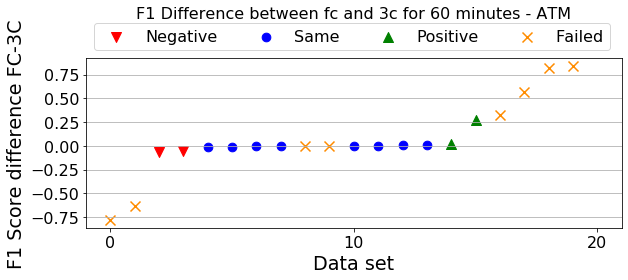

In [10]:
var1 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.atm[(fig.atm.methods == '3c') & (fig.atm.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference FC-3C', 'F1 Difference between fc and 3c for 60 minutes - ATM', fig_size = (9, 4))

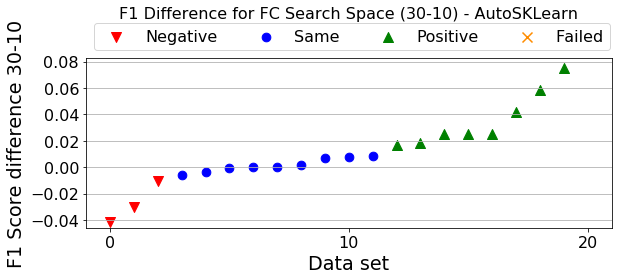

In [11]:
var1 = fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference 30-10', 'F1 Difference for FC Search Space (30-10) - AutoSKLearn', fig_size = (9, 4))

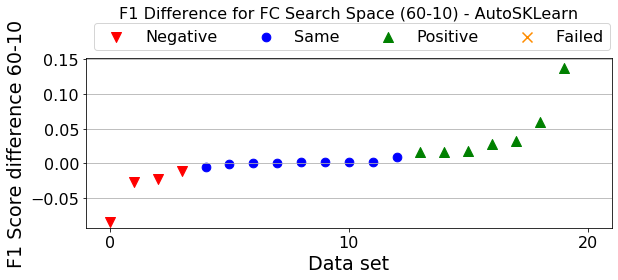

In [12]:
var1 = fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference 60-10', 'F1 Difference for FC Search Space (60-10) - AutoSKLearn', fig_size = (9, 4))

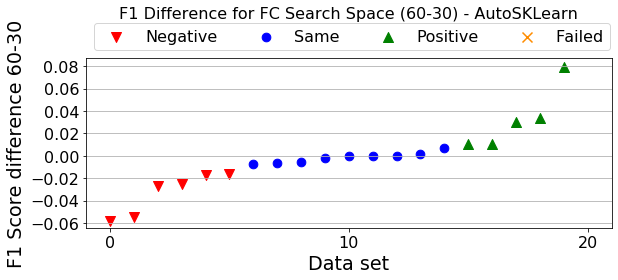

In [13]:
var1 = fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.skout[(fig.skout.methods == 'fc') & (fig.skout.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference 60-30', 'F1 Difference for FC Search Space (60-30) - AutoSKLearn', fig_size = (9, 4))

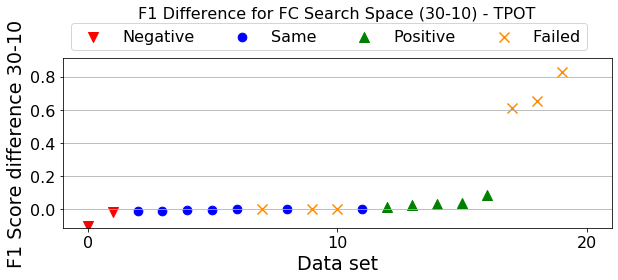

In [14]:
var1 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference 30-10', 'F1 Difference for FC Search Space (30-10) - TPOT', fig_size = (9, 4))

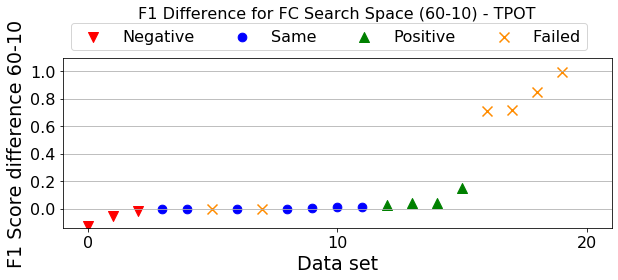

In [15]:
var1 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference 60-10', 'F1 Difference for FC Search Space (60-10) - TPOT', fig_size = (9, 4))

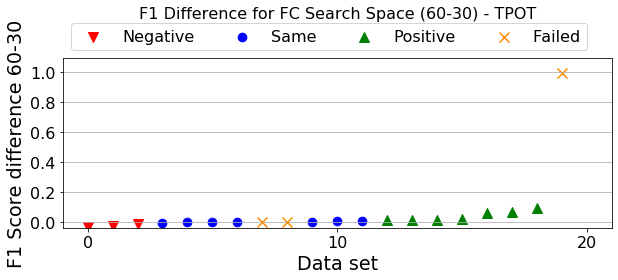

In [16]:
var1 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference 60-30', 'F1 Difference for FC Search Space (60-30) - TPOT', fig_size = (9, 4))

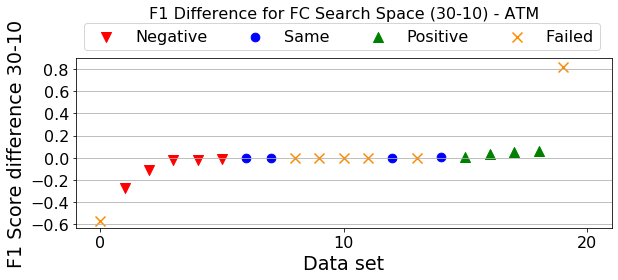

In [17]:
var1 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference 30-10', 'F1 Difference for FC Search Space (30-10) - ATM', fig_size = (9, 4))

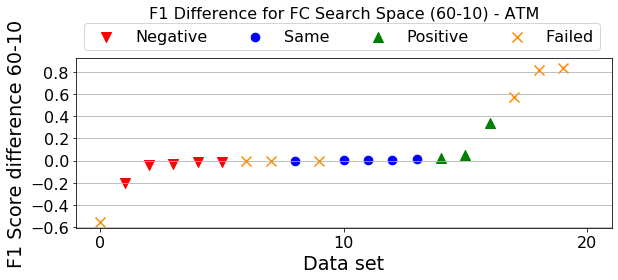

In [18]:
var1 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference 60-10', 'F1 Difference for FC Search Space (60-10) - ATM', fig_size = (9, 4))

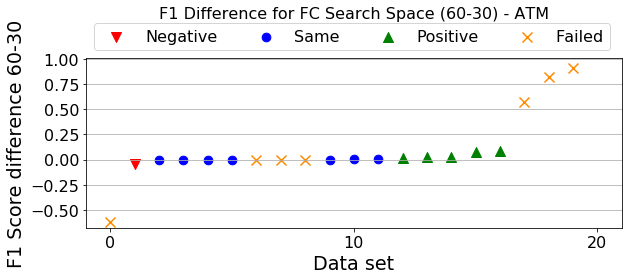

In [19]:
var1 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==30)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference 60-30', 'F1 Difference for FC Search Space (60-30) - ATM', fig_size = (9, 4))

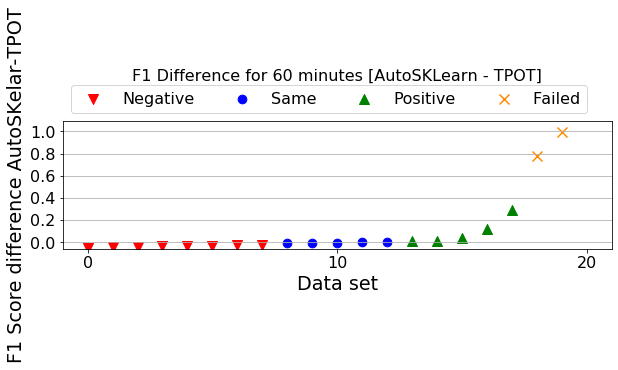

In [20]:
var1 = fig.skout[(fig.skout.dataset.isin(fig.d20)) & (fig.skout.methods == 'fc') & (fig.skout.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference AutoSKelar-TPOT', 'F1 Difference for 60 minutes [AutoSKLearn - TPOT]', fig_size = (9, 4))

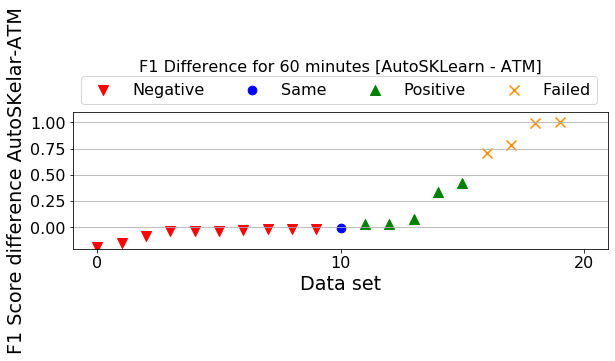

In [21]:
var1 = fig.skout[(fig.skout.dataset.isin(fig.d20)) & (fig.skout.methods == 'fc') & (fig.skout.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference AutoSKelar-ATM', 'F1 Difference for 60 minutes [AutoSKLearn - ATM]', fig_size = (9, 4))

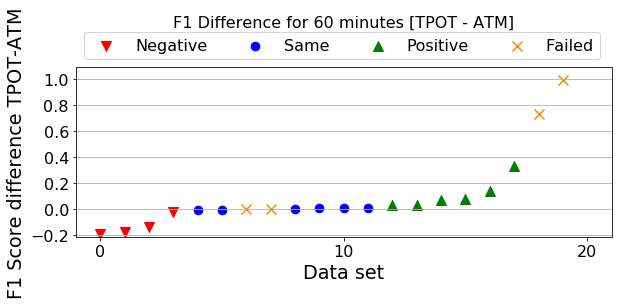

In [22]:
var1 = fig.tpot[(fig.tpot.methods == 'fc') & (fig.tpot.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
var2 = fig.atm[(fig.atm.methods == 'fc') & (fig.atm.time_budget==60)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score
fig.compare_acc_scatter(var1, var2, 'Data set', 'F1 Score difference TPOT-ATM', 'F1 Difference for 60 minutes [TPOT - ATM]', fig_size = (9, 4))

In [23]:
fig.skout[(fig.skout.methods == '3c') & (fig.skout.time_budget==10)].groupby(['dataset', 'time_budget', 'methods']).mean().f1score

dataset                 time_budget  methods
AP_Breast_Lung          10           3c         0.940733
AirlinesCodrnaAdult     10           3c         0.808112
Amazon                  10           3c         0.572444
KDDCup99                10           3c         0.998513
MagicTelescope          10           3c         0.811386
arrhythmia              10           3c         0.878104
audiology               10           3c         0.901632
connect-4               10           3c         0.802309
dataset_31_credit-g     10           3c         0.830183
electricity-normalized  10           3c         0.875600
eye_movements           10           3c         0.649598
gina_agnostic           10           3c         0.917893
hiva_agnostic           10           3c         0.325418
openml_phpJNxH0q        10           3c         0.929488
phpZrCzJR               10           3c         0.995755
pokerhand-normalized    10           3c         0.996269
solar-flare_1           10           3c    